<a href="https://colab.research.google.com/github/yeeecheng/IoT_gesture_remote_car/blob/main/IoT_arm_gesture_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model

In [2]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.15.0



In [3]:
!git clone https://github.com/yeeecheng/IoT_gesture_remote_car.git

Cloning into 'IoT_gesture_remote_car'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 19 (delta 4), reused 19 (delta 4), pack-reused 0
Receiving objects: 100% (19/19), 37.24 KiB | 6.21 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
def Data_Processing(file_root: str, samples_per_gesture: int, gestures: list):

  inputs = []
  outputs = []

  one_hot_encode = np.eye(len(gestures))

  for idx in range(len(gestures)):
    gesture= gestures[idx]
    print(f"Prcessing {gesture}.csv")

    output = one_hot_encode[idx]
    data = pd.read_csv(os.path.join(file_root, gesture + ".csv"))
    num_recording = int(data.shape[0] / samples_per_gesture)

    for i in range(num_recording):
      tensor = []
      for j in range(samples_per_gesture):
        sample_idx = i * samples_per_gesture + j

        # normalize
        # - acceleration is between: -4 to +4
        # - gyroscope is between: -2000 to +200
        tensor += [
          np.float32((data['aX'][sample_idx] + 4) / 8),
          np.float32((data['aY'][sample_idx] + 4) / 8),
          np.float32((data['aZ'][sample_idx] + 4) / 8),
          np.float32((data['gX'][sample_idx] + 2000) / 4000),
          np.float32((data['gY'][sample_idx] + 2000) / 4000),
          np.float32((data['gZ'][sample_idx] + 2000) / 4000)
        ]
      inputs.append(tensor)
      outputs.append(output)
  inputs = np.array(inputs)
  outputs = np.array(outputs)

  return inputs, outputs




In [5]:
def Data_Split(inputs, outputs, ratio, shuffle= False):

  num_inputs = len(inputs)
  if(shuffle):
    randomize = np.arange(num_inputs)
    np.random.shuffle(randomize)
    inputs = inputs[randomize]
    outputs = outputs[randomize]


  LEN = int(num_inputs * ratio)

  # train_X, train_Y, test_X,  test_Y
  return inputs[:LEN], outputs[:LEN], inputs[LEN:], outputs[LEN:]


In [6]:
def Create_Model(input_dim) -> Model:
  model = tf.keras.Sequential([
    Dense(64, activation = "relu", input_shape=(input_dim, )),
    Dense(32, activation = "relu"),
    Dense(7, activation = "softmax")
  ])

  model.summary()
  return model

In [7]:
SAMPLES_PER_GESTURE = 19
GESTURES = ["front", "back", "left", "right", "up", "down", "stop"]
FILE_ROOT = "/content/IoT_gesture_remote_car/dataset"

In [8]:
inputs, outputs = Data_Processing(FILE_ROOT, SAMPLES_PER_GESTURE, GESTURES)
train_X, train_Y, test_X,  test_Y = Data_Split(inputs, outputs, 0.8, shuffle= True)
print(f"train shape {train_X.shape}")
print(f"test shape {test_X.shape}")

Prcessing front.csv
Prcessing back.csv
Prcessing left.csv
Prcessing right.csv
Prcessing up.csv
Prcessing down.csv
Prcessing stop.csv
train shape (56, 114)
test shape (14, 114)


In [9]:
print(type(train_X[0][0]))

<class 'numpy.float32'>


In [10]:
# hyper parameter
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 100

In [11]:
model = Create_Model(train_X.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7360      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 9671 (37.78 KB)
Trainable params: 9671 (37.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= LEARNING_RATE),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits= True),
    metrics= ["accuracy"])
history = model.fit(inputs, outputs, epochs= EPOCHS, batch_size= BATCH_SIZE, validation_data= (test_X, test_Y))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 3s 199ms/step - loss: 2.0020 - accuracy: 0.2571 - val_loss: 1.9210 - val_accuracy: 0.2857
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 1.9450 - accuracy: 0.1714 - val_loss: 1.9363 - val_accuracy: 0.0714
Epoch 3/100
5/5 [==============================] - 0s 69ms/step - loss: 1.9190 - accuracy: 0.1857 - val_loss: 1.9179 - val_accuracy: 0.2143
Epoch 4/100
5/5 [==============================] - 0s 23ms/step - loss: 1.8861 - accuracy: 0.4143 - val_loss: 1.8761 - val_accuracy: 0.3571
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 1.8510 - accuracy: 0.4571 - val_loss: 1.8601 - val_accuracy: 0.2857
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8377 - accuracy: 0.5143 - val_loss: 1.8450 - val_accuracy: 0.4286
Epoch 7/100
5/5 [==============================] - 0s 29ms/step - loss: 1.8358 - accuracy: 0.5286 - val_loss: 1.8320 - val_accuracy: 0.6429
Epoch 8/100
5/5 [==============

In [13]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
import matplotlib.pyplot as plt

def draw_acc_history(history):

    plt.figure()
    plt.plot(history.history["accuracy"], label = 'train acc')
    plt.plot(history.history["val_accuracy"], label = 'val acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.legend()

def draw_loss_history(history):

    plt.figure()
    plt.plot(history.history["loss"], label = 'train loss')
    plt.plot(history.history["val_loss"], label = 'test loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

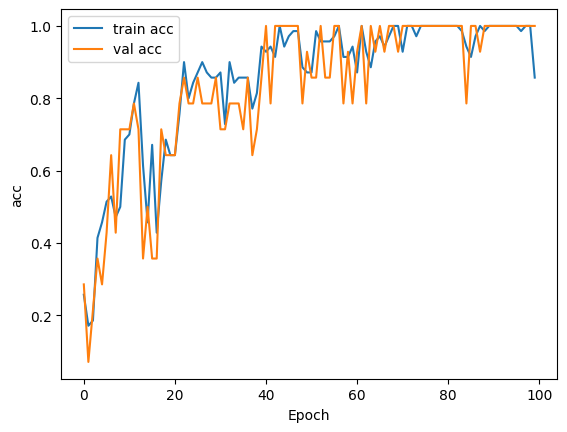

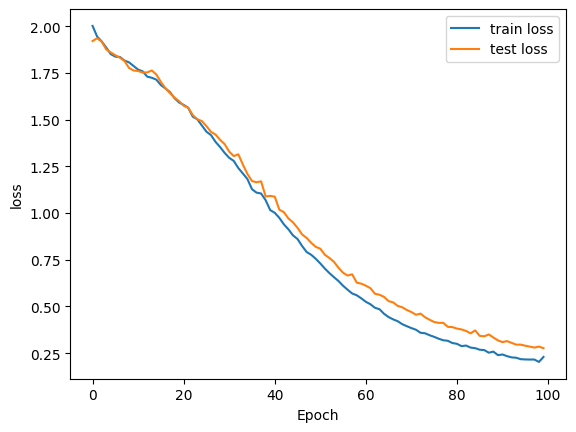

In [15]:
draw_acc_history(history)
draw_loss_history(history)

In [16]:
pred = model.predict(test_X)
test_acc = (pred.argmax(-1) == test_Y.argmax(-1)).mean()
print(f"test acc: {test_acc}")

1/1 [==============================] - 0s 200ms/step
test acc: 1.0


# convert tflite unquantization

In [18]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# convert tflite quantization

In [19]:
#
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_X).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [20]:
# check type
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [55]:
import pathlib

tflite_models_dir = pathlib.Path("/content/weights")
print(tflite_models_dir)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"arm_gesture_model_unquantized_test.tflite"
print(tflite_model_file.write_bytes(tflite_model))
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"arm_gesture_model_quanted_test.tflite"
print(tflite_model_quant_file.write_bytes(tflite_model_quant))

/content/weights
40776
12472


In [49]:
!apt-get update && apt-get -qq install xxd
!xxd -i /content/weights/arm_gesture_model_quanted_test.tflite > model.h
!cat model.h

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
unsigned char _content_weights_arm_gesture_model_quanted_test_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00

In [52]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_X_indices):
  global test_X
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_X_indices),), dtype=int)
  for i, test_X_index in enumerate(test_X_indices):
    test_X_each = test_X[test_X_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.int8:
      input_scale, input_zero_point = input_details["quantization"]
      if(i == 0):
        print(input_scale)
        print(input_zero_point)
      test_X_each = test_X_each / input_scale + input_zero_point


    test_X_each = np.expand_dims(test_X_each, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_X_each)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(output)
    predictions[i] = output.argmax()

  return predictions

In [50]:
import matplotlib.pylab as plt

# Change this to test a different image
test_X_index = range(test_X.shape[0])

## Helper function to test the models on one image
def test_model(tflite_file, test_X_index, model_type):
  global test_labels
  predictions = run_tflite_model(tflite_file, test_X_index)
  print(predictions)
  ground_Y = [ ground.argmax() for ground in test_Y]
  accuracy = (np.sum(ground_Y== predictions) * 100) / len(test_X)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_X)))

In [53]:
test_model(tflite_model_quant_file, test_X_index, model_type="Quantized")

0.00304019614122808
-128
[-127 -128 -127 -125   -7    0 -126]
[-127 -127 -125 -122   41  -62 -118]
[-128   98 -107 -123 -128 -128 -124]
[-128  108 -114 -127 -128 -128 -124]
[-121 -126 -124  106 -125 -123 -128]
[ 122 -128 -126 -124 -128 -128 -128]
[-115 -127 -124   57 -108  -96 -127]
[-128 -128 -127 -127   64  -75 -119]
[-126 -128 -125 -120  -21    7 -126]
[ 110 -128 -123 -115 -128 -128 -128]
[-126 -128 -123 -124   51  -65 -125]
[-128 -121 -125 -127 -116 -127  103]
[-127 -120  113 -127 -125 -127 -127]
[-125 -128 -125 -120  -19    2 -126]
[5 4 1 1 3 0 3 4 5 0 4 6 2 5]
Quantized model accuracy is 100.0000% (Number of test samples=14)
